In [37]:
from pythonMD import manager
import matplotlib.pyplot as plt
import numpy
import pandas
import xarray
import os

# test single particle in 1d

10000 15.370486208650318 1.060563548396872e-22 9.109347535012016e-21 9.215403889851704e-21
20000 1214.0209045852348 8.37674424163812e-21 4.965064042655087e-20 5.8027384668189e-20
30000 47.48712649851926 3.276611728397829e-22 2.3650188750247484e-20 2.3977849923087268e-20
40000 1116.1040491435913 7.70111793909078e-21 3.394948775315181e-20 4.165060569224259e-20
50000 144.11760623859507 9.94411483046306e-22 1.3274970911554903e-20 1.426938239460121e-20
60000 4.629715485053021 3.1945036846865843e-23 9.915978702896427e-20 9.919173206581114e-20
70000 553.38737815336 3.8183729092581845e-21 5.674755679504092e-20 6.05659297042991e-20
80000 146.24441737926253 1.0090864799169115e-21 1.1114021578221018e-20 1.212310805813793e-20
90000 134.27641582775217 9.265072692114901e-22 2.468789280546063e-20 2.561440007467212e-20
100000 1984.9316237162438 1.3696028203642083e-20 9.485960445146352e-20 1.085556326551056e-19


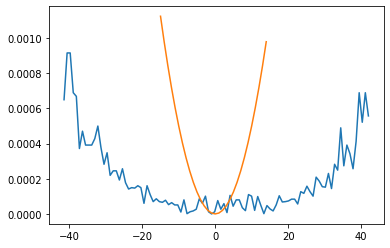

In [20]:
metaDynamicsDict = {"CVs":[{"type":"singleParticlePosition","axis":0}],"sigma":1,"height":0.00025,"pace":100}

myManager = manager(forces=["CoordsEquationPotential"],prop=[("Langevin",0.5),("VelocityVerlet",1.),("Langevin",0.5)],
                    boundariesType=None,dimensions=1,dt=1,metaDynamicsDict=metaDynamicsDict)
myManager.initialize(positions=[[5.]], masses=1,
                     temperature=300 , types=[1])
data = myManager.run(100000,forceEquations=["-1e-5*q"],
                          potentialEquations=["5e-6*(q**2)"],
                          printStats=10000,savePositions=10,printMomentum=1,temperature=300,gamma=0.01)
hist = numpy.histogram([pos[0] for pos in data["positions"]],bins=100)
fes = [-8.617e-7*300*numpy.log(h) for h in hist[0]]

fesmin = min(fes)
plt.plot(hist[1][1:],[val-fesmin for val in fes])
plt.plot([i-15 for i in range(30)],[(i-15)**2*5e-6 for i in range(30)])
# plt.plot(hist[1][1:],hist[0])

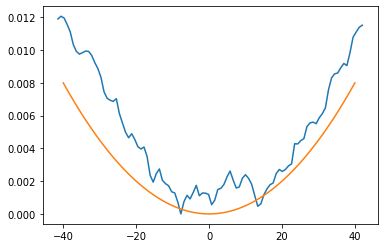

In [21]:
positions = [pos[0][0] for pos in data["positions"]]
hills = data["hills"]['singleParticlePosition']
weights = []
for i in range(len(positions)):
    bias = 0
    for j in range(int(i/10)):
        bias += 0.00025*numpy.exp(-(positions[i]-hills[j])**2/2)
    weights.append(numpy.exp(bias/0.00025))

hist = numpy.histogram(positions,bins=100,weights=weights)
fes = [-8.617e-7*300*numpy.log(h) for h in hist[0]]

fesmin = min(fes)
plt.plot(hist[1][1:],[val-fesmin for val in fes])
plt.plot([i-40 for i in range(81)],[(i-40)**2*5e-6 for i in range(81)])

In [39]:
datalist = []
for filename in os.listdir("results1D"):
    if "positions" in filename:
        with open(os.path.join("results1D",filename), "r") as newfile:
            lines = newfile.readlines()
        datalist.append(pandas.DataFrame(dict(fileSeed=filename[9:],rate=[float(lines[0])],**eval(lines[1]))))
data = pandas.concat(datalist).reset_index().drop(columns="index")
data

,fileSeed,rate,biasFactor,tails,height,width,gamma,simSeed,resetType,thermostat,start,sigma,gHeight,pace
0,20839781606642327,0.0,8,0.000001,0.0025,1.0,0.01,1,Poisson,Langevin,3.0,0.25,0.000125,500
1,871654249858764,0.0,None,0.000001,0.0020,1.0,0.01,1,Poisson,Langevin,3.0,0.25,0.000125,500
2,6219837608588447,0.0,None,0.000001,0.0025,1.0,0.01,1,Poisson,Langevin,3.0,0.25,0.000000,500000000
3,8011747898460653,0.0,None,0.000001,0.0020,1.0,0.01,1,Poisson,Langevin,3.0,0.25,0.000000,500000000
4,6549524228006264,0.0,8,0.000001,0.0020,1.0,0.01,1,Poisson,Langevin,3.0,0.25,0.000125,500


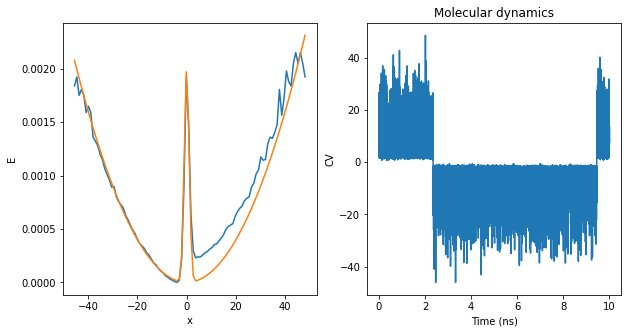

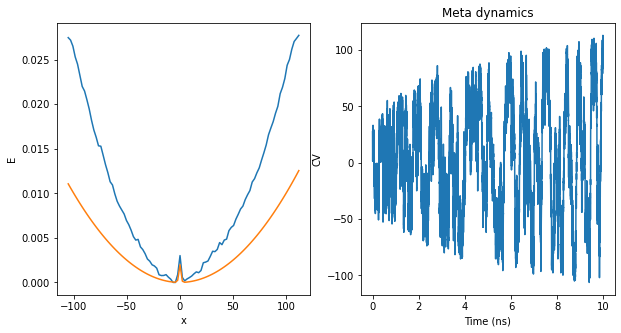

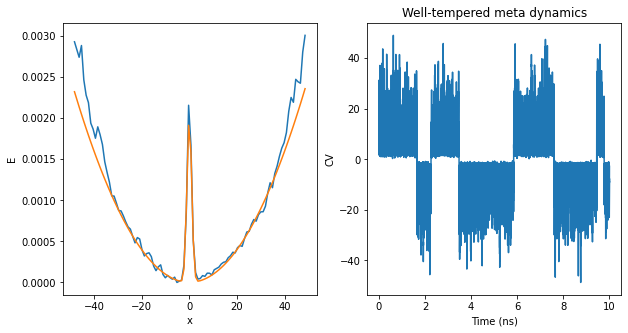

In [45]:
tails = 1e-6
height = 0.002
width =1
metaDynamicsDict = {"CVs":[{"type":"singleParticlePosition","axis":0}],"sigma":0.25,"height":0.000125,"pace":500}

myManager = manager(forces=["CoordsEquationPotential"],prop=[("Langevin",0.5),("VelocityVerlet",1.),("Langevin",0.5)],
                    boundariesType=None,dimensions=1,dt=1,metaDynamicsDict=metaDynamicsDict)
for seed, name in zip([8011747898460653,871654249858764,6549524228006264],["Molecular dynamics","Meta dynamics","Well-tempered meta dynamics"]):
    dataframe = myManager.metaDynamics.getFES(f"results1D/positions{seed}",f"results1D/hills{seed}",300,bins=100)
    analytical = [tails * q ** 2 + height * numpy.exp(-q ** 2 / (2 * width)) for q in dataframe.x]

    with open(f"results1D/positions{seed}", "r") as newfile:
        lines = newfile.readlines()
    coords = []
    for line in lines[2:]:
        coords.append(float(line))

    fig, axs = plt.subplots(1,2,figsize=(10,5))
    axs[0].plot(dataframe.x,dataframe.fes-dataframe.fes.min(),dataframe.x,analytical)
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("E")
    axs[1].set_xlabel("Time (ns)")
    axs[1].set_ylabel("CV")
    axs[1].plot([i*0.00005 for i in range(1,len(coords)+1)],coords)
    plt.title(name)

# 2D

In [40]:
datalist = []
for filename in os.listdir("results"):
    if "positions" in filename:
        with open(os.path.join("results",filename), "r") as newfile:
            lines = newfile.readlines()
        datalist.append(pandas.DataFrame(dict(fileSeed=filename[9:],rate=[float(lines[0])],**eval(lines[1]))))
data = pandas.concat(datalist).reset_index().drop(columns="index")
data

,fileSeed,rate,biasFactor,tailsx,tailsy,height,depth,widthx,widthy,gamma,simSeed,resetType,thermostat,start,sigma,gHeight,pace,axis
0,3545370470932696,0.0,8,4.000000e-09,1.000000e-10,0.0025,0.0005,10.0,500.0,0.01,1,Poisson,Langevin,10.0,0.25,0.000125,500,y
1,5166364296943807,0.0,16,4.000000e-09,1.000000e-10,0.0025,0.0005,10.0,500.0,0.01,1,Poisson,Langevin,10.0,0.25,0.000125,500,x
2,8939778123829315,0.0,8,4.000000e-09,1.000000e-10,0.0025,0.0005,10.0,500.0,0.01,1,Poisson,Langevin,10.0,0.25,0.000125,500,x
3,7669083848753623,0.0,16,4.000000e-09,1.000000e-10,0.0030,0.0010,10.0,100.0,0.01,1,Poisson,Langevin,10.0,0.25,0.000125,500,x
4,7589185506383435,0.0,NaN,4.000000e-09,1.000000e-10,0.0025,0.0005,10.0,500.0,0.01,1,Poisson,Langevin,10.0,0.25,0.000125,500,x
5,034008107233750584,0.0,NaN,4.000000e-09,1.000000e-10,0.0025,0.0005,10.0,500.0,0.01,1,Poisson,Langevin,10.0,0.25,0.000000,500000000,x
6,3342432852677417,0.0,None,4.000000e-09,1.000000e-10,0.0030,0.0010,10.0,100.0,0.01,1,Poisson,Langevin,10.0,0.25,0.000000,500000000,x


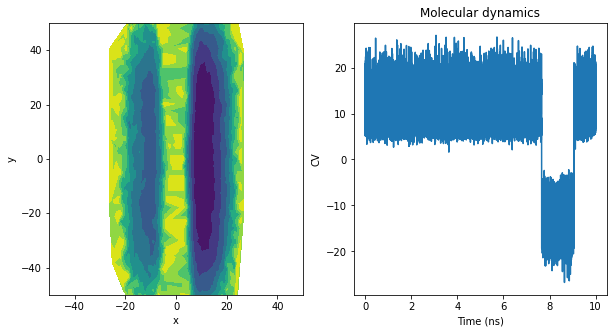

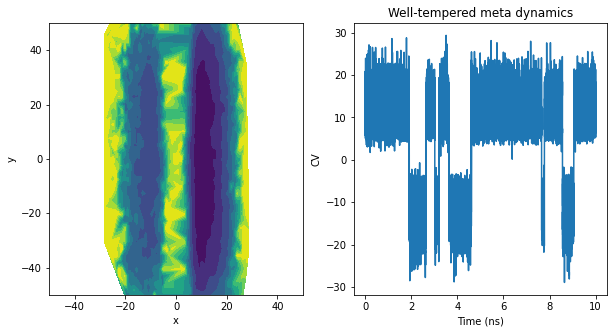

In [42]:
for seed, name in zip([3342432852677417,7669083848753623],["Molecular dynamics","Well-tempered meta dynamics"]):
    metaDynamicsDict = {"CVs":[{"type":"singleParticlePosition","axis":0}],"sigma":0.25,"height":0.000125,"pace":500}

    myManager = manager(forces=["CoordsEquationPotential"],prop=[("Langevin",0.5),("VelocityVerlet",1.),("Langevin",0.5)],
                        boundariesType=None,dimensions=2,dt=1,metaDynamicsDict=metaDynamicsDict)
    dataframe = myManager.metaDynamics.getFES(f"results/positions{seed}",f"results/hills{seed}",300)

    with open(f"results/positions{seed}", "r") as newfile:
        lines = newfile.readlines()
    coords = []
    for line in lines[2:]:
        coords.append(float(line.split(" ")[0]))

    fig, axs = plt.subplots(1,2,figsize=(10,5))
    axs[0].tricontourf(dataframe.x,dataframe.y,dataframe.fes,levels=10)
    axs[0].set_xlim(-50,50)
    axs[0].set_ylim(-50,50)
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("y")
    axs[1].set_xlabel("Time (ns)")
    axs[1].set_ylabel("CV")
    axs[1].plot([i*0.00005 for i in range(1,len(coords)+1)],coords)
    plt.title(name)